In [1]:
import requests
from datetime import date
from calendar import monthrange
import os.path

In [2]:
# https://files.airnowtech.org/airnow/2016/20161101/peak_aqi_usa.jpg
image_url_base = "https://files.airnowtech.org/airnow/{}/{}/peak_aqi_usa.jpg"

# note that there's also an API at https://docs.airnowapi.org/
# but they limit their endpoints to 500/day

# the right way to do this is to use their download api
# for example, in https://files.airnowtech.org/?prefix=airnow/2016/20161108/
# join monitoring_site_locations.dat and daily_data.dat

In [3]:
def download_aqi_images(numdays, directory):
    s = requests.session()
    base = datetime.datetime.today()
    date_list = [base - datetime.timedelta(days=x) for x in range(0, numdays)]
    for date in date_list:
        ymd = "{}{:02}{:02}".format(date.year, date.month, date.day)
        download_file = "{}/{}.jpg".format(directory, ymd)
        if os.path.isfile(download_file):
            continue
        url = image_url_base.format(date.year, ymd)
        r = s.get(url, stream=True)
        if r.status_code == 200:
            with open(download_file, 'wb') as f:
                for chunk in r:
                    f.write(chunk)

In [4]:
from sklearn.cluster import KMeans
import numpy as np

In [5]:
from scipy import misc
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

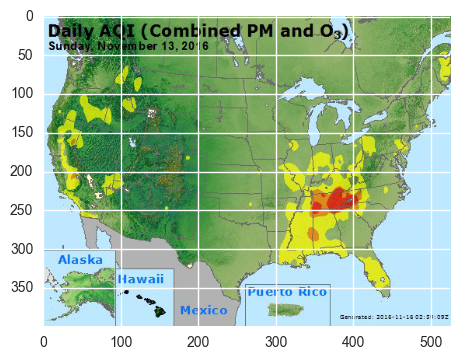

In [6]:
img = misc.imread("pm25_images/20161113.jpg")
plt.imshow(img)

In [7]:
type(img)

numpy.ndarray

In [8]:
img.shape, img.dtype

((400, 525, 3), dtype('uint8'))

In [9]:
img = img.reshape((img.shape[0] * img.shape[1], 3))
img.shape, img.dtype

((210000, 3), dtype('uint8'))

In [10]:
clusters = 10
clt = KMeans(n_clusters = clusters)
clt.fit(img)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [11]:
# from http://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

In [12]:
cluster_histogram = centroid_histogram(clt)

In [13]:
colors = [[x/255 for x in center] for center in clt.cluster_centers_]
colors

[[0.74861387968404625, 0.90773831944444638, 0.9891144658447486],
 [0.45145051920856016, 0.63507052983304491, 0.3430518066434845],
 [0.3120591292789604, 0.51851496178142331, 0.29763722166841283],
 [0.82991025207191782, 0.88756475201052398, 0.14422059370675],
 [0.55536768684180415, 0.68478179664951933, 0.41665457822508156],
 [0.020118828781476972, 0.047473520658246796, 0.031461178221256186],
 [0.69274112994810766, 0.70598868996307984, 0.69158471483495809],
 [0.15118885283930142, 0.48180122568612188, 0.87837808184825195],
 [0.79383092385235854, 0.38064769263271581, 0.1165363836658415],
 [0.14208381917370053, 0.42402463377703858, 0.19236616496685599]]

<Container object of 10 artists>

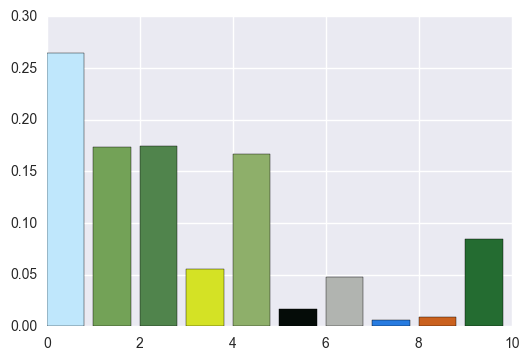

In [14]:
plt.bar(np.arange(len(cluster_histogram)), cluster_histogram, color=colors)

### OK, as fun as that is, the right way to keep going here is to skip the clustering and just count the pixels that are close to the colors provided in the documentation, such as here: https://docs.airnowapi.org/docs/HourlyDataFactSheet.pdf

### however, I next want to explore the API a little bit

In [15]:
import yaml
import datetime

In [16]:
with open("config.yml", 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [17]:
# http://www.airnowapi.org/aq/observation/zipCode/historical/?format=application/json&zipCode=43085&date=2016-11-08T00-0000&distance=25&API_KEY=???
airnow_api_base_url = "http://www.airnowapi.org/aq/observation/zipCode/historical/?format=application/json&zipCode={}&date={}&distance=25&API_KEY={}"

In [18]:
# i've hit my rate limit for the day (only 500 queries!)
# but this should work

def fetch_aqis_for_zipcode(zipcode, numdays, apikey):
    s = requests.session()
    base = datetime.datetime.today()
    date_list = [base - datetime.timedelta(days=x) for x in range(0, numdays)]
    
    aqis = {}
    
    for date in date_list:
        ymd = "{}-{:02}-{:02}T00-0000".format(date.year, date.month, date.day)
        url = airnow_api_base_url.format(zipcode, ymd, apikey)
        r = s.get(url)
        if r.status_code == 200:
            for report in r.json():
                if report['ParameterName'] == 'PM2.5':
                    aqis[date] = report['AQI']
    
    return aqis

In [19]:
aqis = fetch_aqis_for_zipcode(33601, 100, config["airnow_api_key"])

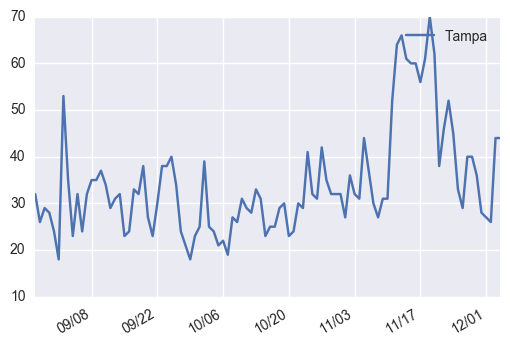

In [20]:
import matplotlib
fig, ax = plt.subplots(1)

dates = sorted(aqis.keys())
aqi_values = [aqis[date] for date in dates]
ax.plot(dates, aqi_values, label="Tampa")

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the
# toolbar
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(myFmt)

plt.legend()

### next up is exploring the file download api from airnow
### we're gonna need pandas for this one!

In [21]:
import pandas as pd

In [22]:
# https://s3-us-west-1.amazonaws.com//files.airnowtech.org/airnow/2016/20161108/daily_data.dat
# or monitoring_site_locations.dat
airnow_file_baseurl = "https://s3-us-west-1.amazonaws.com//files.airnowtech.org/airnow/{}/{}/{}"

In [23]:
date = datetime.datetime.today()

In [24]:
def download_daily_data_and_monitoring(date, directory):
    s = requests.session()
    for file in ['daily_data.dat', 'monitoring_site_locations.dat']:
        ymd = "{}{:02}{:02}".format(date.year, date.month, date.day)
        download_file = "{}/{}-{}".format(directory, ymd, file)
        if os.path.isfile(download_file):
            continue
        url = airnow_file_baseurl.format(date.year, ymd, file)
        r = s.get(url, stream=True)
        if r.status_code == 200:
            with open(download_file, 'wb') as f:
                for chunk in r:
                    f.write(chunk)
        else:
            print(r.status_code)

In [25]:
download_daily_data_and_monitoring(datetime.datetime(2016, 11, 8, 00, 00), "pm25_files")

In [26]:
observations = pd.read_csv("pm25_files/20161109-daily_data.dat", 
                           sep="|", 
                           encoding = "ISO-8859-1",
                           header=None,
                           names=["Valid date", "AQSID", "Sitename", "Parameter name", "Reporting units", "Value", "Averaging period", "Data Source"],
                          )

In [27]:
loc_field_names = ["AQSID", "Parameter name", "Site code", "Sitename", 
                   "Status", "Agency ID", "Agency name", "EPA region", 
                   "Latitude", "Longitude", "Elevation", "GMT offset", 
                   "Country code", "CMSA code", "CMSA name", "MSA code",
                   "MSA name", "State code", "State name", "County code",
                   "County name", "City code", "Nada"]

# we don't want every field here
locs = pd.read_csv("pm25_files/20161109-monitoring_site_locations.dat", 
                   sep="|", 
                   encoding = "ISO-8859-1",
                   header=None,
                   names=loc_field_names,
                   usecols=["AQSID", "Longitude", "Latitude", "State name", "County name"]
                  )
# each site id will have multiple rows based on multiple parameter sensors
locs = locs.drop_duplicates()
locs.head()

,AQSID,Latitude,Longitude,State name,County name
0,000060204,42.3144,-83.0433,CC,ONTARIO
2,000061201,45.0294,-74.7394,CC,ONTARIO
4,000061302,43.1583,-79.2350,CC,ONTARIO
6,000062001,46.3175,-79.4453,CC,ONTARIO
8,000063701,43.3306,-81.7425,CC,ONTARIO


In [28]:
locs = locs.set_index(["AQSID"])
locs.head()

,Latitude,Longitude,State name,County name
AQSID,,,,
000060204,42.3144,-83.0433,CC,ONTARIO
000061201,45.0294,-74.7394,CC,ONTARIO
000061302,43.1583,-79.2350,CC,ONTARIO
000062001,46.3175,-79.4453,CC,ONTARIO
000063701,43.3306,-81.7425,CC,ONTARIO


In [29]:
# we only care about pm2.5
observations = observations[observations["Parameter name"] == "PM2.5-24hr"]
observations = observations.set_index(["AQSID"])
observations.head()

,Valid date,Sitename,Parameter name,Reporting units,Value,Averaging period,Data Source
AQSID,,,,,,,
000020301,11/09/16,WELLINGTON,PM2.5-24hr,UG/M3,11.4,24,Environment Canada
000030701,11/09/16,AYLESFORD MOUNTAIN,PM2.5-24hr,UG/M3,7.2,24,Environment Canada
000040203,11/09/16,FOREST HILLS,PM2.5-24hr,UG/M3,15.0,24,Environment Canada
000040103,11/09/16,FREDERICTON,PM2.5-24hr,UG/M3,9.8,24,Environment Canada
000040207,11/09/16,SAINT JOHN WEST,PM2.5-24hr,UG/M3,16.5,24,Environment Canada


In [30]:
joined = observations.join(locs)

In [31]:
ohio = joined[joined["State name"] == "OH"]

In [32]:
ohio

,Valid date,Sitename,Parameter name,Reporting units,Value,Averaging period,Data Source,Latitude,Longitude,State name,County name
AQSID,,,,,,,,,,,
390490029,11/09/16,New Albany,PM2.5-24hr,UG/M3,4.2,24,Ohio EPA-DAPC,40.084500,-82.815520,OH,FRANKLIN
390350060,11/09/16,G.T.Craig,PM2.5-24hr,UG/M3,4.1,24,Ohio EPA-DAPC,41.492191,-81.678552,OH,CUYAHOGA
390990014,11/09/16,Youngstown - Head St,PM2.5-24hr,UG/M3,5.8,24,Ohio EPA-DAPC,41.095938,-80.658467,OH,MAHONING
391510020,11/09/16,Canton,PM2.5-24hr,UG/M3,2.5,24,Ohio EPA-DAPC,40.800797,-81.372853,OH,STARK
390850007,11/09/16,Painesville - JFS,PM2.5-24hr,UG/M3,4.4,24,Ohio EPA-DAPC,41.726811,-81.242156,OH,LAKE
390030009,11/09/16,Lima,PM2.5-24hr,UG/M3,1.3,24,Ohio EPA-DAPC,40.771000,-84.053900,OH,ALLEN
390870012,11/09/16,Ironton - ODOT,PM2.5-24hr,UG/M3,4.1,24,Ohio EPA-DAPC,38.508114,-82.659301,OH,LAWRENCE
390490034,11/09/16,Columbus - Fairgroun,PM2.5-24hr,UG/M3,1.4,24,Ohio EPA-DAPC,40.002734,-82.994404,OH,FRANKLIN
391650007,11/09/16,Lebanon,PM2.5-24hr,UG/M3,4.1,24,Ohio EPA-DAPC,39.426890,-84.200770,OH,WARREN


In [33]:
# download the last 100 days of files
numdays=100
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(0, numdays)]
for date in date_list:
    print("downloading file for {}".format(date))
    download_daily_data_and_monitoring(date, "pm25_files")

downloading file for 2016-12-03 23:59:57.240572
downloading file for 2016-12-02 23:59:57.240572
downloading file for 2016-12-01 23:59:57.240572
downloading file for 2016-11-30 23:59:57.240572
downloading file for 2016-11-29 23:59:57.240572
downloading file for 2016-11-28 23:59:57.240572
downloading file for 2016-11-27 23:59:57.240572
downloading file for 2016-11-26 23:59:57.240572
downloading file for 2016-11-25 23:59:57.240572
downloading file for 2016-11-24 23:59:57.240572
downloading file for 2016-11-23 23:59:57.240572
downloading file for 2016-11-22 23:59:57.240572
downloading file for 2016-11-21 23:59:57.240572
downloading file for 2016-11-20 23:59:57.240572
downloading file for 2016-11-19 23:59:57.240572
downloading file for 2016-11-18 23:59:57.240572
downloading file for 2016-11-17 23:59:57.240572
downloading file for 2016-11-16 23:59:57.240572
downloading file for 2016-11-15 23:59:57.240572
downloading file for 2016-11-14 23:59:57.240572
downloading file for 2016-11-13 23:59:57

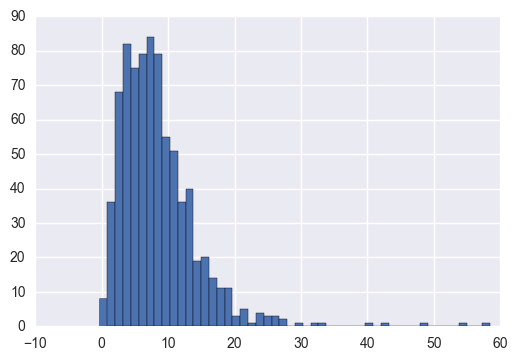

In [34]:
# meanwhile, let's do some desciptive stats of some of our data
joined[pd.notnull(joined["State name"])].Value.hist(bins=50)

In [35]:
joined[pd.notnull(joined["State name"])].describe()

,Value,Averaging period,Latitude,Longitude
count,797.000000,797.0,797.000000,797.000000
mean,8.557967,24.0,39.686555,-97.809647
std,6.057095,0.0,6.911077,19.540284
min,-0.300000,24.0,18.428388,-157.969131
25%,4.500000,24.0,35.500000,-117.059799
50%,7.400000,24.0,40.170000,-94.116700
75%,10.900000,24.0,44.348604,-81.633900
max,58.500000,24.0,64.845800,-52.794700


In [36]:
ohio.describe()

,Value,Averaging period,Latitude,Longitude
count,24.000000,24.0,24.000000,24.000000
mean,3.687500,24.0,40.076072,-83.161955
std,2.165402,0.0,0.933138,1.365256
min,1.300000,24.0,38.508114,-84.720490
25%,2.300000,24.0,39.389843,-84.242108
50%,3.200000,24.0,39.882220,-83.677870
75%,4.250000,24.0,40.865698,-81.862563
max,11.700000,24.0,41.726811,-80.615691


In [37]:
joined[joined.Value > 51]

,Valid date,Sitename,Parameter name,Reporting units,Value,Averaging period,Data Source,Latitude,Longitude,State name,County name
AQSID,,,,,,,,,,,
UB1010001,11/09/16,Ulaanbaatar,PM2.5-24hr,UG/M3,116.3,24,U.S. Department of State Mongolia - Ulaanbaatar,NaN,NaN,NaN,NaN
DK1010001,11/09/16,Dhaka,PM2.5-24hr,UG/M3,69.8,24,U.S. Department of State Bangladesh - Dhaka,NaN,NaN,NaN,NaN
060290014,11/09/16,Bakersfield - Califo,PM2.5-24hr,UG/M3,54.6,24,California Air Resources Board,35.3561,-119.0403,CA,KERN
371730002,11/09/16,BRYSON,PM2.5-24hr,UG/M3,58.5,24,North Carolina DENR - Divison of Air Quality,35.4356,-83.4436,NC,SWAIN
DS1010001,11/09/16,New Delhi,PM2.5-24hr,UG/M3,306.1,24,U.S. Department of State India - New Delhi,NaN,NaN,NaN,NaN
DS1010002,11/09/16,Chennai,PM2.5-24hr,UG/M3,90.6,24,U.S. Department of State India - Chennai,NaN,NaN,NaN,NaN
DS1010003,11/09/16,Kolkata,PM2.5-24hr,UG/M3,196.1,24,U.S. Department of State India - Kolkata,NaN,NaN,NaN,NaN
DS1010005,11/09/16,Hyderabad,PM2.5-24hr,UG/M3,94.0,24,U.S. Department of State India - Hyderabad,NaN,NaN,NaN,NaN
